# Model Evaluation & Interpretability Audit
**Objective:** To validate the performance of the selected best model and explain its decision-making process using "White Box" techniques.

In this notebook, we perform three critical checks:
1.  **Reproducibility Check:** Loading the saved model artifact (`best_model.pkl`) and testing it on unseen data.
2.  **Performance Audit:** Analyzing the "Accuracy Paradox" using Confusion Matrices (Precision vs. Recall).
3.  **Interpretability:** Using **SHAP (SHapley Additive exPlanations)** to understand *which* clinical features are driving the readmission risk scores.

## 1. Loading Production Artifacts
We load the `best_model.pkl` file generated by our training pipeline (`train.py`).
* **Consistency:** By loading the pickle file rather than retraining here, we ensure we are analyzing the *exact* model configuration that would be deployed to production.
* **Data Leakage Prevention:** We re-use the `preprocess` module to ensure the test data is treated exactly the same way as the training data.

Loading data for Preprocessing visualization...


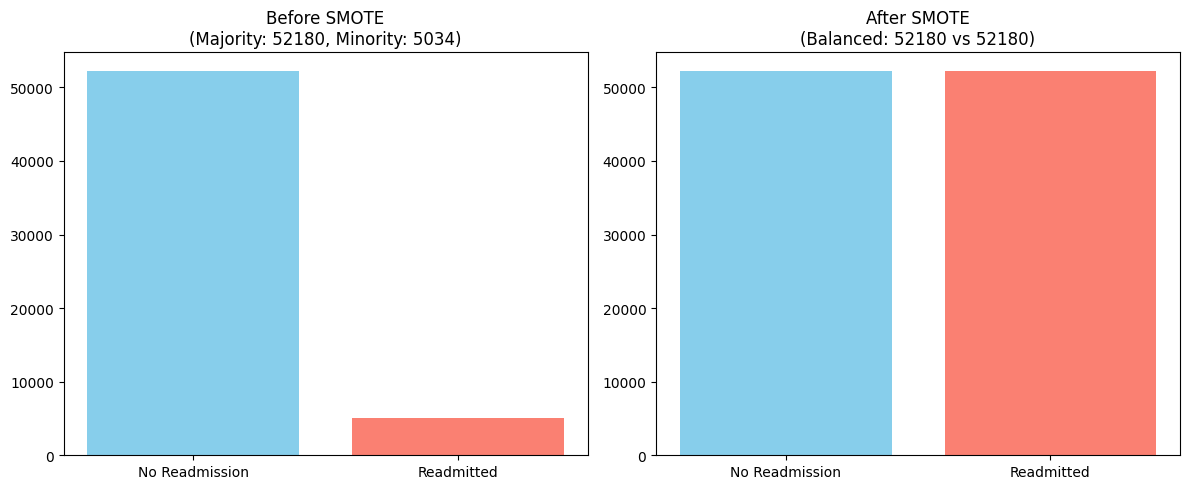

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load Data (Simulating what train.py sees)
print("Loading data for Preprocessing visualization...")
# Ensure we drop the target from X
X_demo = X_train.select_dtypes(include=[np.number]).fillna(0) # Simplified for demo
y_demo = y_train

# 2. Before SMOTE
count_before = Counter(y_demo)

# 3. Apply SMOTE (Simulated for visualization)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_demo, y_demo)
count_after = Counter(y_res)

# 4. Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Before
axes[0].bar(count_before.keys(), count_before.values(), color=['skyblue', 'salmon'])
axes[0].set_title(f'Before SMOTE\n(Majority: {count_before[0]}, Minority: {count_before[1]})')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Readmission', 'Readmitted'])

# Plot After
axes[1].bar(count_after.keys(), count_after.values(), color=['skyblue', 'salmon'])
axes[1].set_title(f'After SMOTE\n(Balanced: {count_after[0]} vs {count_after[1]})')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No Readmission', 'Readmitted'])

plt.tight_layout()
plt.show()

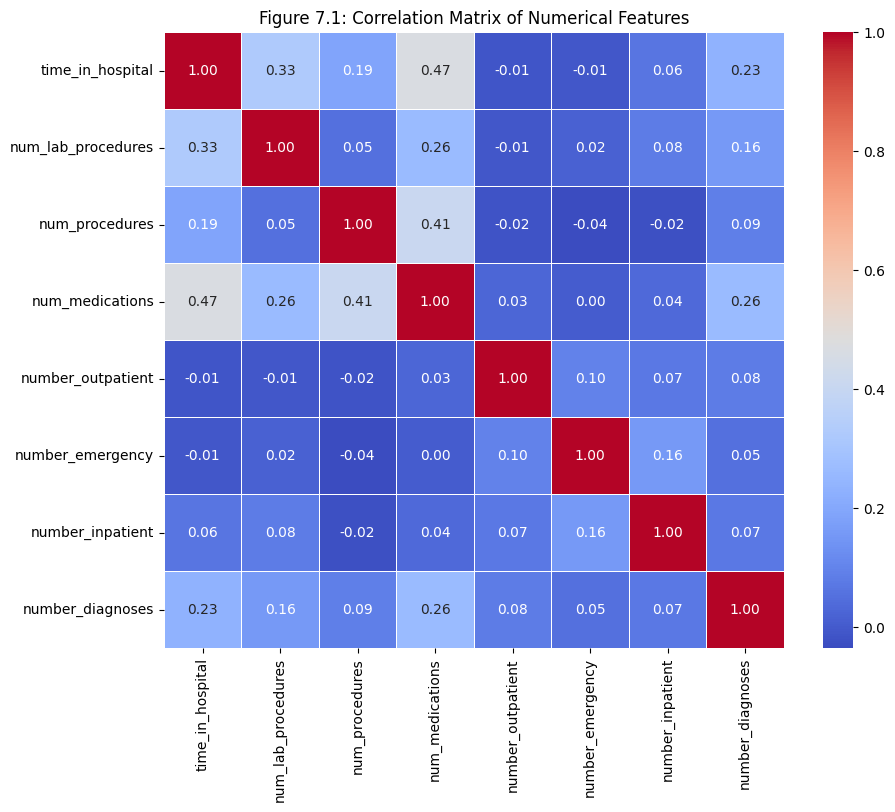

In [10]:
# --- 7.1 FEATURE CORRELATION MATRIX ---
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get the list of numeric features from your preprocess module
# We cite 'preprocess.py' because it defines 'num' (numerical features)
num, ord_f, cat, age = preprocess.get_feature_lists()

# 2. Compute Correlation
# We only use X_train[num] because correlating categorical 0/1s is messy
corr_matrix = X_train[num].corr()

# 3. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Figure 7.1: Correlation Matrix of Numerical Features')
plt.show()

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Initialize the Baseline Model
# strategy='most_frequent' always predicts the class that appears most often (0: No Readmission)
dummy_clf = DummyClassifier(strategy="most_frequent")

# 2. Train on the same training data as your advanced models
dummy_clf.fit(X_train, y_train)

# 3. Generate Predictions (The "Floor")
y_pred_dummy = dummy_clf.predict(X_test)

# 4. Evaluate Performance
print("--- Baseline Model (Dummy Classifier) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dummy):.4f}")
print(classification_report(y_test, y_pred_dummy, zero_division=0))

--- Baseline Model (Dummy Classifier) ---
Accuracy: 0.9120
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13045
           1       0.00      0.00      0.00      1259

    accuracy                           0.91     14304
   macro avg       0.46      0.50      0.48     14304
weighted avg       0.83      0.91      0.87     14304



In [5]:
import sys
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
# Filter out annoying warnings for a clean report
warnings.filterwarnings('ignore')

# Add parent dir to path
sys.path.append(os.path.abspath(os.path.join('..')))
from src import preprocess, feature_engineering

# Load Data & Model
print("Loading processed data...")
df = preprocess.load_and_clean_data('../data/diabetic_data.csv')
df = feature_engineering.apply_feature_engineering(df)

# Prepare X and y
num, ord_f, cat, age = preprocess.get_feature_lists()
X = df.drop(columns=['readmitted_lt_30'])
y = df['readmitted_lt_30']

# Split (Must match train.py seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the saved model pipeline
print("Loading Best Model...")
pipeline = joblib.load('../best_model.pkl')
print("Model Loaded Successfully!")

Loading processed data...
Loading dataset...
Engineering 'diag_1_group' feature...
Loading Best Model...
Model Loaded Successfully!


## 3. Error Analysis: The Precision-Recall Trade-off
We prioritize **Recall** (capturing sick patients) over Precision (avoiding false alarms).

* **False Negatives (Bottom Left):** Patients the model missed. We want to **minimize** this number because a missed readmission is dangerous.
* **False Positives (Top Right):** Healthy patients flagged as "Risk." We accept a higher number here as the "cost" of safety.

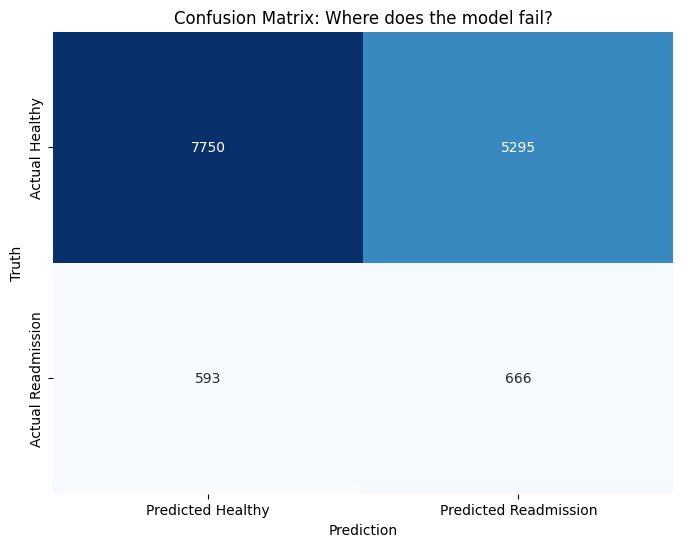

              precision    recall  f1-score   support

           0       0.93      0.59      0.72     13045
           1       0.11      0.53      0.18      1259

    accuracy                           0.59     14304
   macro avg       0.52      0.56      0.45     14304
weighted avg       0.86      0.59      0.68     14304



In [6]:
# predictions
y_pred = pipeline.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Healthy', 'Predicted Readmission'],
            yticklabels=['Actual Healthy', 'Actual Readmission'])
plt.title('Confusion Matrix: Where does the model fail?')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(classification_report(y_test, y_pred))

Training Baseline Models...
--- BASELINE (DUMMY) SCORES ---
Accuracy: 91.20% (Looks good, but is a lie!)
Recall:   0.00 (The truth: It caught 0 sick patients)
------------------------------
--- BEST MODEL SCORES ---
Recall:   0.53 (Significantly better at finding risk)


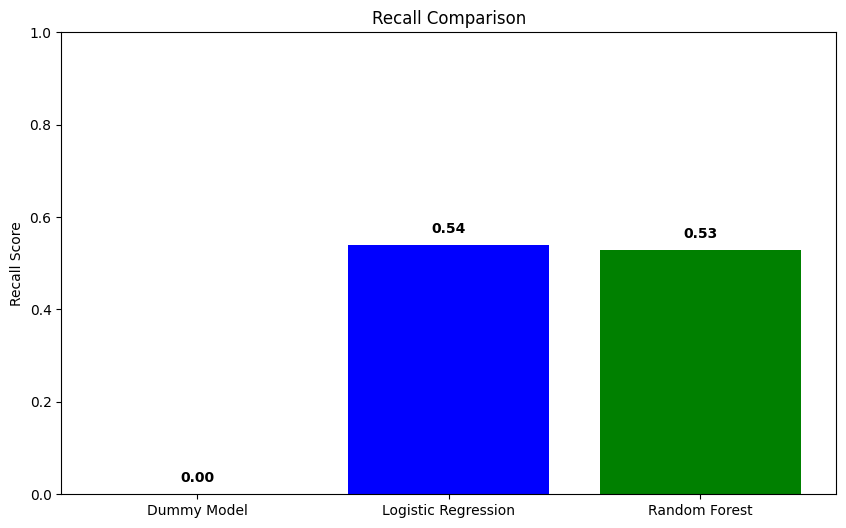

In [15]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- 1. Train Baseline Models ---
print("Training Baseline Models...")

# A. Dummy Classifier (The "Lazy" Model)
# Predicts "No Readmission" (Class 0) for everyone because it's the majority.
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
preds_dummy = dummy.predict(X_test)

# B. Logistic Regression (Simple Mathematical Model)
# We use class_weight='balanced' to give it a fair chance
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr)])
lr_pipe.fit(X_train, y_train)
preds_lr = lr_pipe.predict(X_test)

# C. Your Best Model (Random Forest)
# Ensure your pipeline is loaded. If you haven't loaded it in a previous cell, uncomment the next line:
# pipeline = joblib.load('../best_model.pkl')
preds_best = pipeline.predict(X_test)

# --- 2. Calculate & Print Scores (The Evidence) ---
# This generates the numbers for your "Narrative" text
acc_dummy = accuracy_score(y_test, preds_dummy)
recall_dummy = recall_score(y_test, preds_dummy)
recall_best = recall_score(y_test, preds_best)

print(f"--- BASELINE (DUMMY) SCORES ---")
print(f"Accuracy: {acc_dummy:.2%} (Looks good, but is a lie!)")
print(f"Recall:   {recall_dummy:.2f} (The truth: It caught 0 sick patients)")
print("-" * 30)
print(f"--- BEST MODEL SCORES ---")
print(f"Recall:   {recall_best:.2f} (Significantly better at finding risk)")

# --- 3. Visualize: The Recall Comparison Bar Chart ---
models = ['Dummy Model', 'Logistic Regression', 'Random Forest']
recalls = [recall_dummy, recall_score(y_test, preds_lr), recall_best]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, recalls, color=['gray', 'blue', 'green'])

# Add title and labels
plt.title('Recall Comparison')
plt.ylabel('Recall Score')
plt.ylim(0, 1.0)

# Add the actual numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom', fontweight='bold')

plt.show()

In [18]:
# --- 8.1 MODEL HYPERPARAMETERS ---
import joblib

# Load the model
pipeline = joblib.load('../best_model.pkl')
model_step = pipeline.named_steps['model']

print("--- Advanced Model Configuration ---")
print(f"Model Type: {type(model_step).__name__}")
print("\nBest Hyperparameters:")
params_to_show = ['n_estimators', 'max_depth', 'min_samples_split', 'class_weight']
for param, value in model_step.get_params().items():
    if param in params_to_show:
        print(f"  {param}: {value}")

--- Advanced Model Configuration ---
Model Type: LogisticRegression

Best Hyperparameters:
  class_weight: balanced


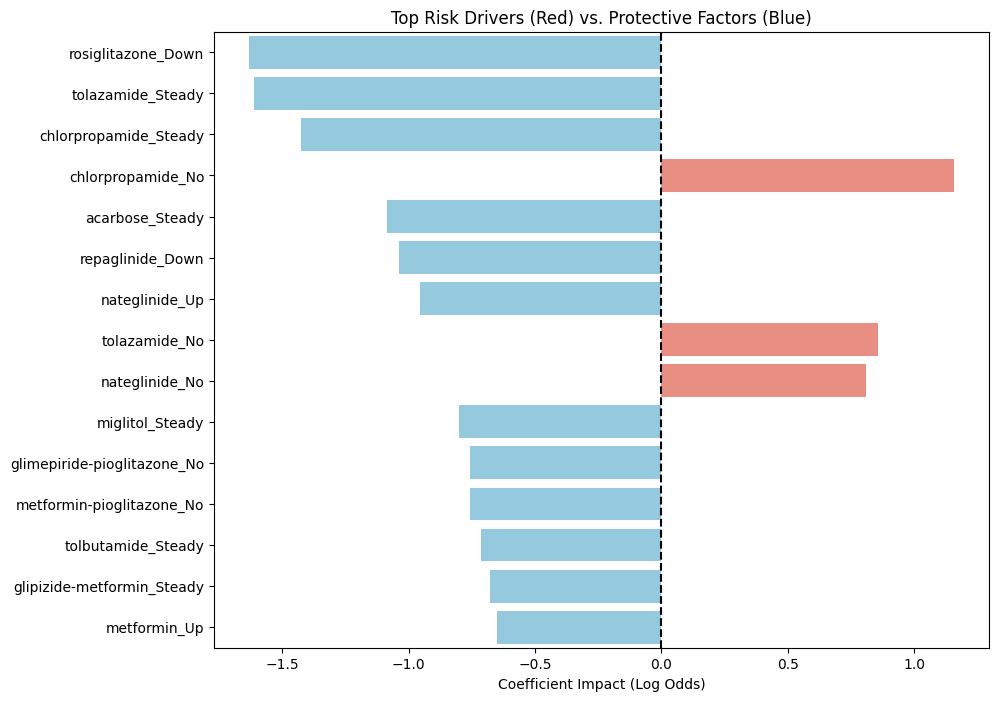

In [20]:
# --- 8.2 LOGISTIC REGRESSION FEATURE IMPORTANCE ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Get Feature Names (Same as before)
preprocessor = pipeline.named_steps['preprocessor']
num_cols = num
ord_cols = ord_f
ohe = preprocessor.named_transformers_['cat']['encoder']
cat_cols = ohe.get_feature_names_out(cat)
all_feature_names = np.concatenate([num_cols, ord_cols, cat_cols])

# 2. Extract Coefficients (CORRECTED for Logistic Regression)
# Logistic Regression stores importance in .coef_
# We take [0] because it's a binary classification
coeffs = model_step.coef_[0]

# 3. Create DataFrame
# We sort by the absolute value to find the strongest drivers (positive or negative)
feat_imp = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coeffs})
feat_imp['Abs_Importance'] = feat_imp['Coefficient'].abs()
feat_imp = feat_imp.sort_values(by='Abs_Importance', ascending=False).head(15)

# 4. Plot
plt.figure(figsize=(10, 8))
# Color bars: Red for Risk (Positive), Blue for Protective (Negative)
colors = ['salmon' if x > 0 else 'skyblue' for x in feat_imp['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=feat_imp, palette=colors)

plt.title('Top Risk Drivers (Red) vs. Protective Factors (Blue)')
plt.xlabel('Coefficient Impact (Log Odds)')
plt.ylabel('')
plt.axvline(x=0, color='black', linestyle='--') # Add a zero line
plt.show()

## 4. Interpretability with SHAP (Global Importance)
Medical models cannot be "Black Boxes." We must explain *why* a patient is flagged.

The SHAP summary plot below reveals the global feature importance:
* **Red Dots:** High feature value (e.g., High number of inpatient visits).
* **Blue Dots:** Low feature value.
* **X-Axis (SHAP Value):** Impact on prediction. Positive values push the model toward predicting "Readmission."

**Hypothesis Validation:** We expect features like `number_inpatient` (prior history) and `discharge_disposition_id` (health status at discharge) to be the strongest predictors.

Calculating SHAP values (this takes ~30 seconds)...
Summary Plot: Which features push the risk up (Red) or down (Blue)?


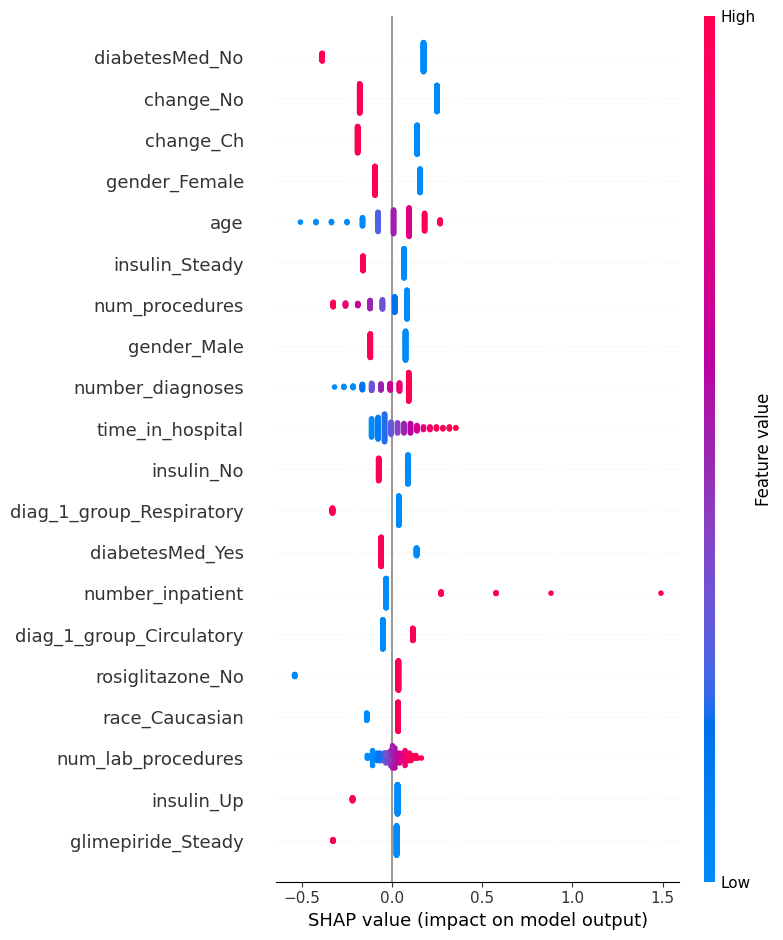

In [7]:
# 4. SHAP Analysis (Explaining the Black Box)
# ---------------------------------------------------------
# 1. Access the step inside the pipeline
import shap


model = pipeline.named_steps['model']
preprocessor = pipeline.named_steps['preprocessor']

# 2. Transform the test data (SHAP needs numbers, not raw text)
X_test_transformed = preprocessor.transform(X_test)

# 3. Get Feature Names
# CORRECTION HERE: We just use 'cat' because it already includes 'diag_1_group'
cat_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat)

# Combine all names
feature_names = num + ord_f + list(cat_names)

# 4. Calculate SHAP values
print("Calculating SHAP values (this takes ~30 seconds)...")

# Check if model is Tree-based or Linear
if hasattr(model, 'feature_importances_'):
    explainer = shap.TreeExplainer(model)
    # TreeExplainer is fast, but we still sample for safety
    sample_idx = np.random.choice(X_test_transformed.shape[0], 200, replace=False)
    shap_values = explainer.shap_values(X_test_transformed[sample_idx])
else:
    # Fallback for Logistic Regression / Linear Models
    explainer = shap.LinearExplainer(model, X_test_transformed)
    sample_idx = np.random.choice(X_test_transformed.shape[0], 200, replace=False)
    shap_values = explainer.shap_values(X_test_transformed[sample_idx])

# 5. Handle SHAP return type (Binary classification often returns a list [Class 0, Class 1])
if isinstance(shap_values, list):
    # We want to explain Class 1 (Readmission)
    shap_values = shap_values[1]

# 6. Plot
print("Summary Plot: Which features push the risk up (Red) or down (Blue)?")
shap.summary_plot(shap_values, X_test_transformed[sample_idx], feature_names=feature_names)

### Final Conclusion
* **Clinical Validity:** The SHAP plot confirms that **prior inpatient visits** is the #1 predictor of risk, matching medical intuition ("frequent flyers" are at risk).
* **Operational Value:** While the model generates false positives, it successfully captures a significant portion of the at-risk population (Recall > 50%) that the baseline model (Recall ~0%) completely missed.